## Reading uv-vis spectrophotometry files

In [8]:
from empylib.spectrometry import read_uvvis
help(read_uvvis)

Help on function read_uvvis in module empylib.spectrometry:

read_uvvis(path: str, vendor: Optional[str] = None, col1_name: Optional[str] = None, col2_name: Optional[str] = None) -> pandas.core.frame.DataFrame
    Unified UV-Vis reader for Shimadzu (.txt) and PerkinElmer (.asc) files.
    
    This is the public entry point that dispatches to vendor-specific
    raw readers (hidden functions), then applies common logic to build
    a tidy `pandas.DataFrame`.
    
    Parameters
    ----------
    path : str
        Path to the UV-Vis data file.
    vendor : str, optional
        Explicit vendor name ("shimadzu" or "perkinelmer").
        If not given, it is inferred from the file extension.
    col1_name : str, optional
        Override for the first column name (x-axis).
        Default is "wavelength (µm)" (converted from nm).
    col2_name : str, optional
        Override for the second column name (y-axis).
        Default is taken from the file if available, otherwise inferred.
  

### Shimadzu measurements

In [3]:
df = read_uvvis("Tdif_PMMA_1fv_CaCO3.txt", col2_name = "Tdif")
df.head()

,Tdif
wavelength (µm),
0.220,0.00124
0.221,0.00130
0.222,0.00132
0.223,0.00116
0.224,0.00094


In [4]:
df.attrs

{'instrument': 'Shimadzu', 'sample_name': None}

### Perkin Elmer measurements

In [5]:
df = read_uvvis("PerkinElmer_sample.asc", col2_name= "Rtot")
df.head()

,Rtot
wavelength (µm),
2.500,0.010696
2.495,0.013704
2.490,0.006373
2.485,0.011535
2.480,0.005792


## Extracting bundle meassurements


In [6]:
from empylib.spectrometry import sample_uvvis
help(sample_uvvis)

Help on function sample_uvvis in module empylib.spectrometry:

sample_uvvis(sample: str = None, search_dirs: Optional[Iterable[str]] = None, tags: Optional[List[str]] = None, aliases: Optional[Dict[str, List[str]]] = None, exts: Tuple[str, ...] = ('.txt', '.asc')) -> pandas.core.frame.DataFrame
    Aggregate UV-Vis measurements for a given sample into a single DataFrame.
    Also derives the third component per family (R*, T*) via: total = diffuse + specular.
    
    Files searched (case-insensitive), by default:
      Rtot, Ttot, Rspec, Tspec, Rdif, Tdif
    Exact-name patterns per tag (sample kept exactly as passed):
      <tag>_<sample>.txt | <tag>_<sample>.asc
      <tag_lower>_<sample>.txt | <tag_lower>_<sample>.asc
      
    Parameters
    ----------
    sample : str, optional
        Sample name to look for in filenames (e.g. "MySample").
        If None, defaults to the sample files stored in "search_dirs".
    search_dirs : Iterable[str], optional
        List of directories

In [ ]:
sample = sample_uvvis(sample = 'PMMA_1fv_CaCO3')
sample.head()

,Tdif,Tspec,Ttot
wavelength (µm),,,
0.220,0.00124,0.00040,0.00164
0.221,0.00130,0.00025,0.00155
0.222,0.00132,0.00017,0.00149
0.223,0.00116,0.00021,0.00137
0.224,0.00094,0.00044,0.00138


In [7]:
sample.attrs

{'instrument': 'Shimadzu', 'sample_name': 'PMMA_1fv_CaCO3'}

# Finding samples and extracting data

In [1]:
from empylib.spectrometry import find_uvvis_samples
help(find_uvvis_samples)

Help on function find_uvvis_samples in module empylib.spectrometry:

find_uvvis_samples(search_dirs: Optional[Iterable[str]] = None, tags: Optional[List[str]] = None, aliases: Optional[Dict[str, List[str]]] = None, exts: Tuple[str, ...] = ('.txt', '.asc')) -> List[str]
    Find UV-Vis sample names by scanning files named <tag>_<sample><ext>.
    - Case-insensitive for tags/aliases and extensions.
    - Keeps the sample name exactly as it appears in filenames (after the first separator).
    Parameters
    ----------
    search_dirs : Iterable[str], optional
        List of directories to search for files.
        If None, defaults to ["."], the current directory.
    tags : List[str], optional
        List of tags to look for in filenames.
        If None, defaults to:
        ["Rtot", "Ttot", "Rspec", "Tspec", "Rdif", "Tdif"].
    aliases : Dict[str, List[str]], optional
        Mapping of tag → list of alternative names to try.
        If None, defaults to:
        {
            "Rto

In [3]:
samples = find_uvvis_samples(
    search_dirs = ["./uvvis_sample_data"])
print(samples)

['MezclaToluenoCaCO3', 'PMMApaint_CacO3_10vv', 'PMMApaint_CaCO3_15vv']


In [10]:
df_data = {}
for s in samples:
    df_data[s] = sample_uvvis(sample = s, 
                              search_dirs = ["./uvvis_sample_data"])

## Plot samples with a formated linestyle

In [13]:
from empylib.spectrometry import linestyle
help(linestyle)

Help on function linestyle in module empylib.spectrometry:

linestyle(sample: pandas.core.frame.DataFrame, linestyles: Dict = {'tot': '-', 'spec': ':', 'dif': '--'}, colors: Dict = {'R': 'r', 'T': 'b', 'A': 'k'}) -> str
    Generate matplotlib line styles for UV-Vis DataFrame columns.
    E.g. {"Rtot": "-r", "Tspec": ":b", "Rdif": "--r"}.
    
    Parameters
    ----------
    sample : pandas.DataFrame
        DataFrame with columns named like Rtot, Tspec, Rdif, Atot, etc.
    linestyles : Dict, optional
        Mapping of line type keywords to matplotlib line styles.
        Defaults to {"tot": "-", "spec": ":", "dif": "--"}.
    colors : Dict, optional
        Mapping of measurement type keywords to colors.
        Defaults to {"R": "r", "T": "b", "A": "k"}.
    
    Returns
    -------
    Dict[str, str]
        Dictionary mapping each column name to a matplotlib style string.
        E.g. {"Rtot": "-r", "Tspec": ":b", "Rdif": "--r"}
    
    Notes
    -----
    - The function looks

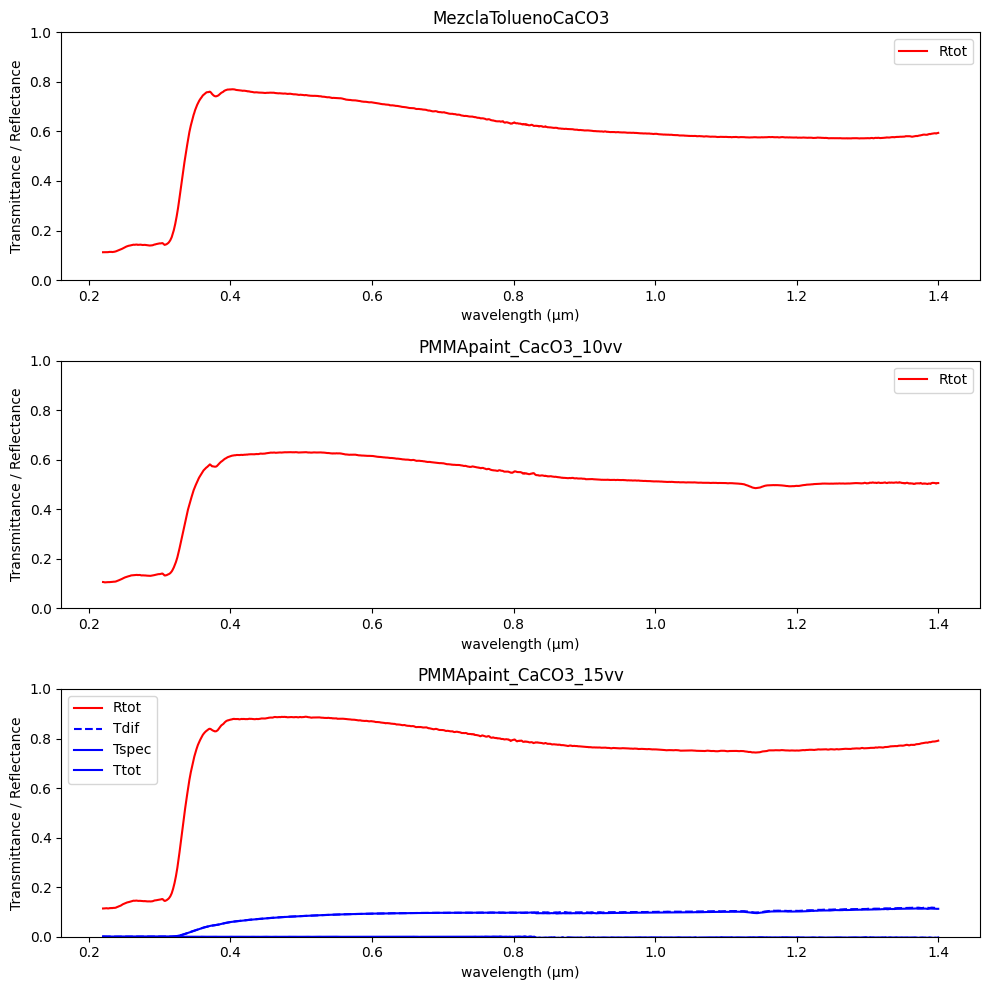

In [14]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=len(samples), 
                       figsize=(10,10), 
                       tight_layout=True)

for i, s in enumerate(samples):
   df_data[s].plot(
      style= linestyle(df_data[s]),
      title = s,
      ylabel = 'Transmittance / Reflectance',
      ax = ax[i]
   )
   ax[i].set_ylim(0,1)